<a href="https://colab.research.google.com/github/Jaseel-beep/jas2wanderlust/blob/main/Impact_Analy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
import pandas as pd
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import zipfile
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, concatenate, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [123]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [124]:
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_set.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_set.csv")

In [125]:
# Display the first few rows of the train dataset to understand its structure
train_df.head()

Image Index  Finding Labels  Follow-up  Patient ID  Patient Age  \
0  00000011_000.png               0          0          11           75   
1  00000013_011.png               1         11          13           60   
2  00000013_012.png               1         12          13           60   
3  00000013_013.png               1         13          13           60   
4  00000013_036.png               1         36          13           56   

  Patient Gender View Position  OriginalImage_Width  OriginalImage_Height  \
0              M            PA                 2638                  2449   
1              M            AP                 3056                  2544   
2              M            AP                 3056                  2544   
3              M            AP                 3056                  2544   
4              M            PA                 2952                  2968   

   OriginalImagePixelSpacing_x  OriginalImagePixelSpacing_y  
0                        0.143                        0.143  
1                        0.139                        0.139  
2                        0.139                        0.139  
3                        0.139                        0.139  
4                        0.143                        0.143

In [ ]:
# Encode categorical features
train_df['Patient Gender'] = train_df['Patient Gender'].map({'M': 0, 'F': 1})
test_df['Patient Gender'] = test_df['Patient Gender'].map({'M': 0, 'F': 1})

In [127]:
# One-hot encoding for 'View Position'
train_df = pd.get_dummies(train_df, columns=['View Position'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['View Position'], drop_first=True)

In [128]:
# Handle missing values if any
train_df.fillna(method='ffill', inplace=True)
test_df.fillna(method='ffill', inplace=True)

In [129]:
# Define image directory path
test_zip_path = '/content/drive/MyDrive/Colab Notebooks/test_images/test_images.zip'
train_zip_path = '/content/drive/MyDrive/Colab Notebooks/test_images/train_images.zip'

In [ ]:
import zipfile
import os

In [ ]:
# Extract train images
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/Colab Notebooks/test_images/train_images')

In [ ]:
# Extract test images
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/Colab Notebooks/test_images/test_images')

In [ ]:
# Define directories
train_image_dir = '/content/drive/MyDrive/Colab Notebooks/test_images/train_images/'
test_image_dir = '/content/drive/MyDrive/Colab Notebooks/test_images/test_images/'

In [ ]:
# Preprocess Images with Error Handling
import cv2
import numpy as np

In [130]:
# Function to preprocess images
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, (128, 128))
        img = img / 255.0
        img = np.expand_dims(img, axis=-1)
    else:
        img = np.zeros((128, 128, 1))
    return img

def load_images(image_dir, image_index):
    images = []
    for img_name in image_index:
        img_path = os.path.join(image_dir, img_name)
        img = preprocess_image(img_path)
        images.append(img)
    return np.array(images)

In [131]:
train_image_index = train_df['Image Index'].tolist()
test_image_index = test_df['Image Index'].tolist()

In [132]:
train_images = load_images(train_image_dir, train_image_index)
test_images = load_images(test_image_dir, test_image_index)

In [133]:
# Prepare structured data and labels
structured_columns = ['Follow-up', 'Patient Age', 'Patient Gender', 'View Position_PA',
                      'OriginalImage_Width', 'OriginalImage_Height',
                      'OriginalImagePixelSpacing_x', 'OriginalImagePixelSpacing_y']

In [136]:
# Make sure the 'Patient Gender' and 'View Position_PA' columns are properly encoded
train_df['Patient Gender'] = train_df['Patient Gender'].map({'M': 0, 'F': 1})
train_df['View Position_PA'] = train_df['View Position_PA'].map({'AP': 0, 'PA': 1})

test_df['Patient Gender'] = test_df['Patient Gender'].map({'M': 0, 'F': 1})
test_df['View Position_PA'] = test_df['View Position_PA'].map({'AP': 0, 'PA': 1})

In [137]:
# Prepare structured data and labels
structured_columns = ['Follow-up', 'Patient Age', 'Patient Gender', 'View Position_PA',
                      'OriginalImage_Width', 'OriginalImage_Height',
                      'OriginalImagePixelSpacing_x', 'OriginalImagePixelSpacing_y']

train_structured_data = train_df[structured_columns].copy()
test_structured_data = test_df[structured_columns].copy()

In [138]:
# Standardize the structured data
scaler = StandardScaler()
train_structured_data = scaler.fit_transform(train_structured_data)
test_structured_data = scaler.transform(test_structured_data)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [146]:
# Check for NaN or infinite values
train_structured_data = np.nan_to_num(train_structured_data)
test_structured_data = np.nan_to_num(test_structured_data)

In [147]:
# Extract labels and handle class imbalance if necessary
train_labels = train_df['Finding Labels'].values
test_labels = test_df['Finding Labels'].values

In [148]:
# Define a CNN model with VGG16 for transfer learning
def create_cnn(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    return Model(inputs=base_model.input, outputs=x)

cnn_model = create_cnn((128, 128, 3))

In [149]:
# Prepare structured data input
structured_input = Input(shape=(train_structured_data.shape[1],))
combined = concatenate([cnn_model.output, structured_input])

In [142]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [150]:
# Add final layers
x = Dense(128, activation='relu')(combined)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

In [151]:
model = Model(inputs=[cnn_model.input, structured_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [152]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 128, 128, 64)         1792      ['input_12[0][0]']            
                                                                                                  
 block1_conv2 (Conv2D)       (None, 128, 128, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)           0         ['block1_conv2[0][0]']        
                                                                                            

In [153]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [154]:
# Callbacks
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001)

# Split data into training and validation sets
X_train_img, X_val_img, X_train_struct, X_val_struct, y_train, y_val = train_test_split(
    train_images, train_structured_data, train_labels, test_size=0.2, random_state=42
)

In [155]:
# Train the model
history = model.fit(
    datagen.flow([X_train_img, X_train_struct], y_train, batch_size=32),
    validation_data=([X_val_img, X_val_struct], y_val),
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node model_9/block1_conv1/Relu defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-155-e1ddc2518a1b>", line 2, in <cell line: 2>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/activations.py", line 306, in relu

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5395, in relu

input depth must be evenly divisible by filter depth: 1 vs 3
	 [[{{node model_9/block1_conv1/Relu}}]] [Op:__inference_train_function_46536]

In [156]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate([test_images, test_structured_data], test_labels)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1917, in test_step
        y_pred = self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model_9' (type Functional).
    
    Input 0 of layer "block1_conv1" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 128, 128, 1)
    
    Call arguments received by layer 'model_9' (type Functional):
      • inputs=('tf.Tensor(shape=(None, 128, 128, 1), dtype=float32)', 'tf.Tensor(shape=(None, 8), dtype=float32)')
      • training=False
      • mask=None


In [134]:
train_structured_data = train_df[structured_columns].copy()
test_structured_data = test_df[structured_columns].copy()

In [ ]:
# Load and preprocess images
def load_images(image_dir, image_index):
    images = []
    for img_name in image_index:
        img_path = os.path.join(image_dir, img_name)
        img = preprocess_image(img_path)
        images.append(img)
    return np.array(images)

In [ ]:
# Example usage
train_image_index = train_df['Image Index'].tolist()
test_image_index = test_df['Image Index'].tolist()

In [ ]:
train_images = load_images(train_image_dir, train_image_index)
test_images = load_images(test_image_dir, test_image_index)

Streaming output truncated to the last 5000 lines.
Error processing image /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025529_015.png: Image not found or cannot be read at /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025529_015.png
Error processing image /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025529_016.png: Image not found or cannot be read at /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025529_016.png
Error processing image /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025529_021.png: Image not found or cannot be read at /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025529_021.png
Error processing image /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025543_011.png: Image not found or cannot be read at /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025543_011.png
Error processing image /content/drive/MyDrive/Colab Noteb

In [ ]:
#Prepare Structured Data and Labels
from sklearn.preprocessing import StandardScaler

In [ ]:
# Convert categorical columns to numerical and standardize the structured data
structured_columns = ['Follow-up', 'Patient Age', 'Patient Gender', 'View Position_PA',
                      'OriginalImage_Width', 'OriginalImage_Height',
                      'OriginalImagePixelSpacing_x', 'OriginalImagePixelSpacing_y']

In [ ]:
train_structured_data = train_df[structured_columns].copy()
test_structured_data = test_df[structured_columns].copy()

In [ ]:
print(train_df.columns)
print(test_df.columns)

Index(['Image Index', 'Finding Labels', 'Follow-up', 'Patient ID',
       'Patient Age', 'Patient Gender', 'OriginalImage_Width',
       'OriginalImage_Height', 'OriginalImagePixelSpacing_x',
       'OriginalImagePixelSpacing_y', 'View Position_PA'],
      dtype='object')
Index(['Image Index', 'Finding Labels', 'Follow-up', 'Patient ID',
       'Patient Age', 'Patient Gender', 'OriginalImage_Width',
       'OriginalImage_Height', 'OriginalImagePixelSpacing_x',
       'OriginalImagePixelSpacing_y', 'View Position_PA'],
      dtype='object')


In [ ]:
# Convert categorical columns to numerical
train_structured_data['Patient Gender'] = train_structured_data['Patient Gender'].map({'M': 0, 'F': 1})
train_structured_data['View Position_PA'] = train_structured_data['View Position_PA'].map({'AP': 0, 'PA': 1})

test_structured_data['Patient Gender'] = test_structured_data['Patient Gender'].map({'M': 0, 'F': 1})
test_structured_data['View Position_PA'] = test_structured_data['View Position_PA'].map({'AP': 0, 'PA': 1})

In [ ]:
# Standardize the structured data
scaler = StandardScaler()
train_structured_data = scaler.fit_transform(train_structured_data)
test_structured_data = scaler.transform(test_structured_data)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [ ]:
# Extract labels
train_labels = train_df['Finding Labels'].values
test_labels = test_df['Finding Labels'].values

In [ ]:
# Model Development and Training
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, concatenate, Conv2D, MaxPooling2D, Flatten


In [ ]:
# Define a simple CNN model for image feature extraction
def create_cnn(input_shape):
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(input_img)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    return Model(inputs=input_img, outputs=x)

In [ ]:
# Image feature extraction model
cnn_model = create_cnn((128, 128, 1))


In [ ]:
# Prepare structured data input
structured_input = Input(shape=(train_structured_data.shape[1],))


In [ ]:
# Combine image features and structured data
combined = concatenate([cnn_model.output, structured_input])



In [ ]:
# Add final layers
x = Dense(64, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(x)  # Assuming binary classification (0 or 1)


In [ ]:
# Define the model
model = Model(inputs=[cnn_model.input, structured_input], outputs=output)


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Display the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 32)         320       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 61, 61, 64)           18496     ['max_pooling2d[0][0]'] 

In [ ]:
#Training
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train_img, X_val_img, X_train_struct, X_val_struct, y_train, y_val = train_test_split(
    train_images, train_structured_data, train_labels, test_size=0.2, random_state=42
)

# Train the model
history = model.fit(
    [X_train_img, X_train_struct], y_train,
    validation_data=([X_val_img, X_val_struct], y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
108/108 [==============================] - 7s 18ms/step - loss: nan - accuracy: 0.6455 - val_loss: nan - val_accuracy: 0.6341
Epoch 2/10
108/108 [==============================] - 1s 11ms/step - loss: nan - accuracy: 0.6455 - val_loss: nan - val_accuracy: 0.6341
Epoch 3/10
108/108 [==============================] - 1s 11ms/step - loss: nan - accuracy: 0.6455 - val_loss: nan - val_accuracy: 0.6341
Epoch 4/10
108/108 [==============================] - 1s 11ms/step - loss: nan - accuracy: 0.6455 - val_loss: nan - val_accuracy: 0.6341
Epoch 5/10
108/108 [==============================] - 1s 11ms/step - loss: nan - accuracy: 0.6455 - val_loss: nan - val_accuracy: 0.6341
Epoch 6/10
108/108 [==============================] - 1s 11ms/step - loss: nan - accuracy: 0.6455 - val_loss: nan - val_accuracy: 0.6341
Epoch 7/10
108/108 [==============================] - 1s 11ms/step - loss: nan - accuracy: 0.6455 - val_loss: nan - val_accuracy: 0.6341
Epoch 8/10
108/108 [=====================

In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate([test_images, test_structured_data], test_labels)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


135/135 [==============================] - 1s 5ms/step - loss: nan - accuracy: 0.6432
Test Loss: nan, Test Accuracy: 0.6432055830955505


In [ ]:
# Make PRedictions
# Get model predictions
predictions = model.predict([test_images, test_structured_data])
predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary output


135/135 [==============================] - 1s 3ms/step


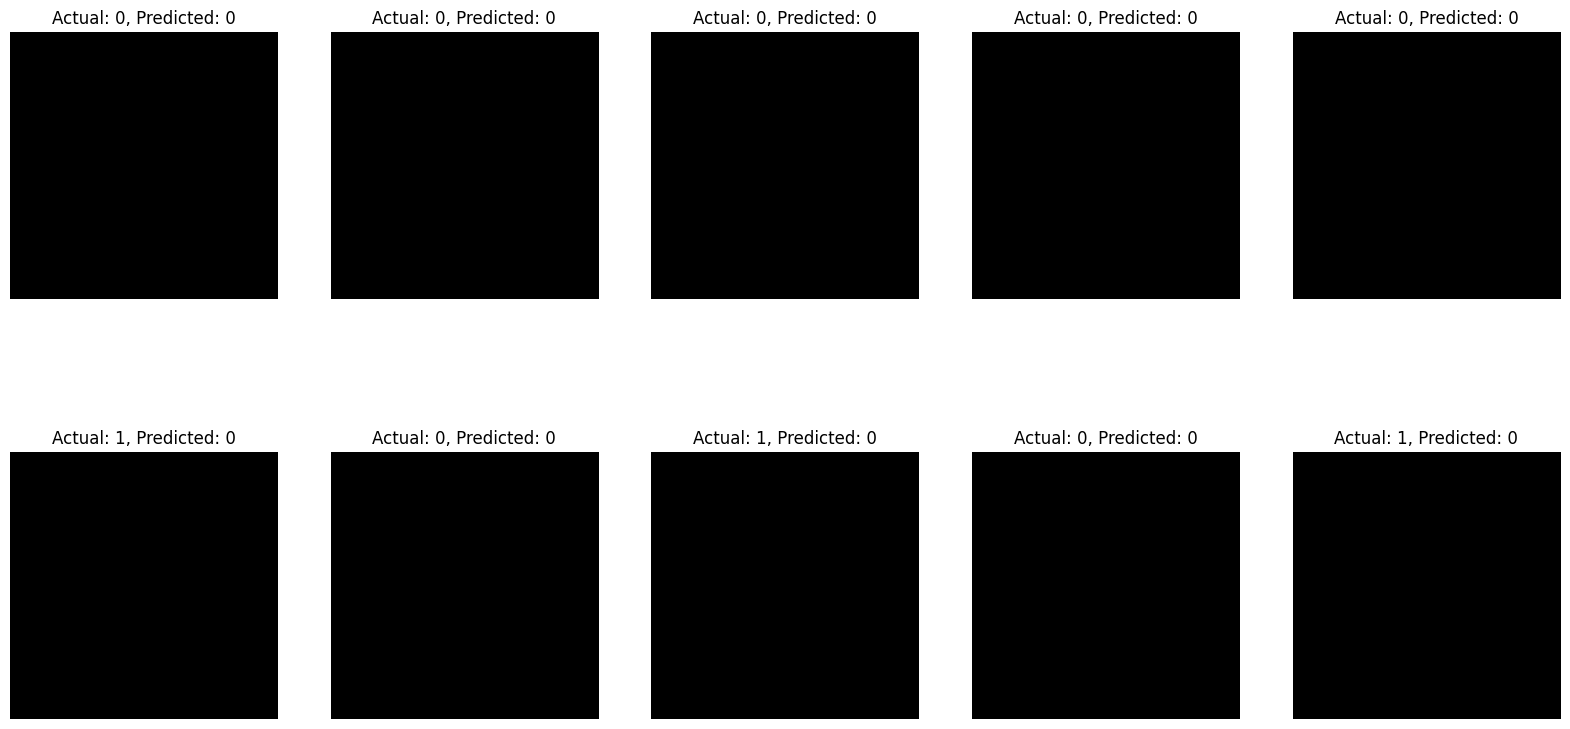

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize predictions
def visualize_predictions(images, labels, predictions, indices):
    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[idx].reshape(128, 128), cmap='gray')
        plt.title(f'Actual: {labels[idx]}, Predicted: {predictions[idx][0]}')
        plt.axis('off')
    plt.show()

# Select random indices to visualize
import random
random_indices = random.sample(range(len(test_images)), 10)

# Visualize predictions
visualize_predictions(test_images, test_labels, predictions, random_indices)


In [ ]:
# Get model predictions
predictions = model.predict([test_images, test_structured_data])
predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary output

135/135 [==============================] - 0s 3ms/step


In [ ]:
# Load the sample submission file
submission_df = pd.read_csv('/content/sample_submission.csv')

In [ ]:
# Ensure that the predictions are in the correct shape
predictions = predictions.flatten()


In [ ]:
# Assign the predictions to the 'Finding Labels' column
submission_df['Finding Labels'] = predictions

ValueError: Length of values (4305) does not match length of index (1844)

In [ ]:
print("Length of predictions:", len(predictions))
print("Length of submission index:", len(submission_df))


Length of predictions: 4305
Length of submission index: 1844


In [ ]:
# Assuming the predictions should match the submission_df length
if len(predictions) != len(submission_df):
    predictions = predictions[:len(submission_df)]

# Assign the predictions to the 'Finding Labels' column
submission_df['Finding Labels'] = predictions.flatten()

# Save the results to a new CSV file
submission_file_path = '/content/sample_submission.csv'
submission_df.to_csv(submission_file_path, index=False)

submission_file_path


'/content/sample_submission.csv'

In [ ]:
submission_file_path

'/content/sample_submission.csv'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply data augmentation to training images
train_datagen = datagen.flow(train_images, train_labels, batch_size=32)


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

In [ ]:
# Load pre-trained ResNet50 model + higher level layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
# Add new top layers for our specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


In [ ]:
# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
# Freeze the layers of the base model to prevent training them initially
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Display the model architecture
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
# Train the model
history = model.fit(
    train_datagen,
    steps_per_epoch=len(train_images) // 32,
    validation_data=([X_val_img, X_val_struct], y_val),
    epochs=20
)

Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node model_2/conv1_conv/Conv2D defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-62-4788b5eeeb53>", line 2, in <cell line: 2>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op

input depth must be evenly divisible by filter depth: 1 vs 3
	 [[{{node model_2/conv1_conv/Conv2D}}]] [Op:__inference_train_function_19444]

In [ ]:
# Unfreeze the top layers of the base model
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [ ]:
# Compile the model with a lower learning rate
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Continue training the model
history = model.fit(
    train_datagen,
    steps_per_epoch=len(train_images) // 32,
    validation_data=([X_val_img, X_val_struct], y_val),
    epochs=20
)

Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node model_2/conv1_conv/Conv2D defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-65-723692bd2a8e>", line 2, in <cell line: 2>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op

input depth must be evenly divisible by filter depth: 1 vs 3
	 [[{{node model_2/conv1_conv/Conv2D}}]] [Op:__inference_train_function_25493]

In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate([test_images, test_structured_data], test_labels)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1917, in test_step
        y_pred = self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_2" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 128, 128, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 8) dtype=float32>]


In [ ]:
# Function to preprocess images to have 3 channels
def preprocess_image(image_path):
    try:
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Load image in RGB
        if img is None:
            raise ValueError(f"Image not found or cannot be read at {image_path}")
        img = cv2.resize(img, (128, 128))  # Resize image to 128x128
        img = img / 255.0  # Normalize pixel values
        return img
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        # Return a blank image if an error occurs
        return np.zeros((128, 128, 3))

In [ ]:
# Load and preprocess images
def load_images(image_dir, image_index):
    images = []
    for img_name in image_index:
        img_path = os.path.join(image_dir, img_name)
        img = preprocess_image(img_path)
        images.append(img)
    return np.array(images)

In [ ]:
# Reload images with the new preprocessing
train_images = load_images(train_image_dir, train_image_index)
test_images = load_images(test_image_dir, test_image_index)

Streaming output truncated to the last 5000 lines.
Error processing image /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025529_015.png: Image not found or cannot be read at /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025529_015.png
Error processing image /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025529_016.png: Image not found or cannot be read at /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025529_016.png
Error processing image /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025529_021.png: Image not found or cannot be read at /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025529_021.png
Error processing image /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025543_011.png: Image not found or cannot be read at /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025543_011.png
Error processing image /content/drive/MyDrive/Colab Noteb

In [ ]:
import os
import cv2
import numpy as np

In [ ]:
# Function to preprocess images to have 3 channels
def preprocess_image(image_path):
    try:
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Load image in RGB
        if img is None:
            raise ValueError(f"Image not found or cannot be read at {image_path}")
        img = cv2.resize(img, (128, 128))  # Resize image to 128x128
        img = img / 255.0  # Normalize pixel values
        return img
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        # Return None to indicate that the image is missing or unreadable
        return None

In [ ]:
# Load and preprocess images
def load_images(image_dir, image_index):
    images = []
    valid_indices = []
    for i, img_name in enumerate(image_index):
        img_path = os.path.join(image_dir, img_name)
        img = preprocess_image(img_path)
        if img is not None:
            images.append(img)
            valid_indices.append(i)
    return np.array(images), valid_indices

In [ ]:
# Example usage
train_image_index = train_df['Image Index'].tolist()
test_image_index = test_df['Image Index'].tolist()

In [ ]:
train_images, valid_train_indices = load_images(train_image_dir, train_image_index)
test_images, valid_test_indices = load_images(test_image_dir, test_image_index)


Streaming output truncated to the last 5000 lines.
Error processing image /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025529_015.png: Image not found or cannot be read at /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025529_015.png
Error processing image /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025529_016.png: Image not found or cannot be read at /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025529_016.png
Error processing image /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025529_021.png: Image not found or cannot be read at /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025529_021.png
Error processing image /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025543_011.png: Image not found or cannot be read at /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025543_011.png
Error processing image /content/drive/MyDrive/Colab Noteb

In [ ]:
# Filter the structured data and labels to include only the valid indices
train_structured_data = train_structured_data[valid_train_indices]
train_labels = train_labels[valid_train_indices]
test_structured_data = test_structured_data[valid_test_indices]
test_labels = test_labels[valid_test_indices]


In [ ]:
# Train the model
history = model.fit(
    datagen.flow([train_images, train_structured_data], train_labels, batch_size=32),
    steps_per_epoch=len(train_images) // 32,
    validation_data=([X_val_img, X_val_struct], y_val),
    epochs=20
)

ValueError: ('Input data in `NumpyArrayIterator` should have rank 4. You passed an array with shape', (0,))

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, structured_data, labels, batch_size, datagen):
        self.images = images
        self.structured_data = structured_data
        self.labels = labels
        self.batch_size = batch_size
        self.datagen = datagen
        self.indices = np.arange(len(images))

    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = self.images[batch_indices]
        batch_structured_data = self.structured_data[batch_indices]
        batch_labels = self.labels[batch_indices]

        augmented_images = np.zeros_like(batch_images)

        for i in range(len(batch_images)):
            augmented_images[i] = self.datagen.random_transform(batch_images[i])

        return [augmented_images, batch_structured_data], batch_labels

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

In [ ]:
# Create an instance of the custom data generator
batch_size = 32
train_generator = CustomDataGenerator(train_images, train_structured_data, train_labels, batch_size, datagen)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // batch_size,
    validation_data=([X_val_img, X_val_struct], y_val),
    epochs=20
)

ValueError: Unexpected value for `steps_per_epoch`. Received value is 0. Please check the docstring for `model.fit()` for supported values.

In [ ]:
# Ensure steps_per_epoch is at least 1
steps_per_epoch = max(1, len(train_images) // batch_size)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=([X_val_img, X_val_struct], y_val),
    epochs=20
)

Epoch 1/20


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_2" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None,) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, None) dtype=float32>]


In [ ]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, structured_data, labels, batch_size, datagen):
        self.images = images
        self.structured_data = structured_data
        self.labels = labels
        self.batch_size = batch_size
        self.datagen = datagen
        self.indices = np.arange(len(images))

    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = self.images[batch_indices]
        batch_structured_data = self.structured_data[batch_indices]
        batch_labels = self.labels[batch_indices]

        augmented_images = np.zeros_like(batch_images)

        for i in range(len(batch_images)):
            augmented_images[i] = self.datagen.random_transform(batch_images[i])

        return [augmented_images, batch_structured_data], batch_labels

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

In [ ]:
# Create an instance of the custom data generator
batch_size = 32
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = CustomDataGenerator(train_images, train_structured_data, train_labels, batch_size, datagen)

# Ensure steps_per_epoch is at least 1
steps_per_epoch = max(1, len(train_images) // batch_size)

In [ ]:
# Ensure steps_per_epoch is at least 1
steps_per_epoch = max(1, len(train_images) // batch_size)

In [ ]:
# Use the original validation data split
X_val_img = load_images(train_image_dir, valid_train_indices)  # Adjust this line to fit your validation data loading
X_val_struct = train_structured_data[valid_train_indices]
y_val = train_labels[valid_train_indices]

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=([X_val_img, X_val_struct], y_val),
    epochs=20
)

Epoch 1/20


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_2" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None,) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, None) dtype=float32>]


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
# Load pre-trained ResNet50 model + higher level layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [ ]:
# Add new top layers for our specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
image_features = Dense(64, activation='relu')(x)

In [ ]:
# Input for structured data
structured_input = Input(shape=(train_structured_data.shape[1],))
structured_features = Dense(64, activation='relu')(structured_input)

In [ ]:
# Combine image features and structured data
combined = concatenate([image_features, structured_features])


In [ ]:
# Add final layers
x = Dense(64, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(x)  # Assuming binary classification (0 or 1)

In [ ]:
# Define the full model
model = Model(inputs=[base_model.input, structured_input], outputs=output)

In [ ]:
# Compile the model
model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Display the model architecture
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, structured_data, labels, batch_size, datagen):
        self.images = images
        self.structured_data = structured_data
        self.labels = labels
        self.batch_size = batch_size
        self.datagen = datagen
        self.indices = np.arange(len(images))

    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = self.images[batch_indices]
        batch_structured_data = self.structured_data[batch_indices]
        batch_labels = self.labels[batch_indices]

        augmented_images = np.zeros_like(batch_images)

        for i in range(len(batch_images)):
            augmented_images[i] = self.datagen.random_transform(batch_images[i])

        return [augmented_images, batch_structured_data], batch_labels

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

In [ ]:
# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Create an instance of the custom data generator
batch_size = 32
train_generator = CustomDataGenerator(train_images, train_structured_data, train_labels, batch_size, datagen)

In [ ]:
# Ensure steps_per_epoch is at least 1
steps_per_epoch = max(1, len(train_images) // batch_size)

In [ ]:
# Ensure you have validation data prepared correctly
X_val_img = test_images  # Assuming test_images is already prepared
X_val_struct = test_structured_data  # Assuming test_structured_data is already prepared
y_val = test_labels  # Assuming test_labels is already prepared

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=([X_val_img, X_val_struct], y_val),
    epochs=20
)

Epoch 1/20


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model_3' (type Functional).
    
    Input 0 of layer "conv1_pad" is incompatible with the layer: expected ndim=4, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'model_3' (type Functional):
      • inputs=('tf.Tensor(shape=(None,), dtype=float32)', 'tf.Tensor(shape=(None, None), dtype=float32)')
      • training=True
      • mask=None


In [ ]:
import os
import cv2
import numpy as np

# Function to preprocess images to have 3 channels
def preprocess_image(image_path):
    try:
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Load image in RGB
        if img is None:
            raise ValueError(f"Image not found or cannot be read at {image_path}")
        img = cv2.resize(img, (128, 128))  # Resize image to 128x128
        img = img / 255.0  # Normalize pixel values
        return img
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        # Return None to indicate that the image is missing or unreadable
        return None

# Load and preprocess images
def load_images(image_dir, image_index):
    images = []
    valid_indices = []
    for i, img_name in enumerate(image_index):
        img_path = os.path.join(image_dir, img_name)
        img = preprocess_image(img_path)
        if img is not None:
            images.append(img)
            valid_indices.append(i)
    return np.array(images), valid_indices

# Example usage
train_image_index = train_df['Image Index'].tolist()
test_image_index = test_df['Image Index'].tolist()

train_images, valid_train_indices = load_images(train_image_dir, train_image_index)
test_images, valid_test_indices = load_images(test_image_dir, test_image_index)

# Filter the structured data and labels to include only the valid indices
train_structured_data = train_structured_data[valid_train_indices]
train_labels = train_labels[valid_train_indices]
test_structured_data = test_structured_data[valid_test_indices]
test_labels = test_labels[valid_test_indices]


Streaming output truncated to the last 5000 lines.
Error processing image /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025529_015.png: Image not found or cannot be read at /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025529_015.png
Error processing image /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025529_016.png: Image not found or cannot be read at /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025529_016.png
Error processing image /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025529_021.png: Image not found or cannot be read at /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025529_021.png
Error processing image /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025543_011.png: Image not found or cannot be read at /content/drive/MyDrive/Colab Notebooks/test_images/train_images/00025543_011.png
Error processing image /content/drive/MyDrive/Colab Noteb

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, structured_data, labels, batch_size, datagen):
        self.images = images
        self.structured_data = structured_data
        self.labels = labels
        self.batch_size = batch_size
        self.datagen = datagen
        self.indices = np.arange(len(images))

    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = self.images[batch_indices]
        batch_structured_data = self.structured_data[batch_indices]
        batch_labels = self.labels[batch_indices]

        augmented_images = np.zeros_like(batch_images)

        for i in range(len(batch_images)):
            augmented_images[i] = self.datagen.random_transform(batch_images[i])

        return [augmented_images, batch_structured_data], batch_labels

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create an instance of the custom data generator
batch_size = 32
train_generator = CustomDataGenerator(train_images, train_structured_data, train_labels, batch_size, datagen)

# Ensure steps_per_epoch is at least 1
steps_per_epoch = max(1, len(train_images) // batch_size)


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load pre-trained ResNet50 model + higher level layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add new top layers for our specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
image_features = Dense(64, activation='relu')(x)

# Input for structured data
structured_input = Input(shape=(train_structured_data.shape[1],))
structured_features = Dense(64, activation='relu')(structured_input)

# Combine image features and structured data
combined = concatenate([image_features, structured_features])

# Add final layers
x = Dense(64, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(x)  # Assuming binary classification (0 or 1)

# Define the full model
model = Model(inputs=[base_model.input, structured_input], outputs=output)

# Compile the model
model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_6[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
# Ensure you have validation data prepared correctly
X_val_img = test_images  # Assuming test_images is already prepared
X_val_struct = test_structured_data  # Assuming test_structured_data is already prepared
y_val = test_labels  # Assuming test_labels is already prepared

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=([X_val_img, X_val_struct], y_val),
    epochs=20
)


Epoch 1/20


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model_4' (type Functional).
    
    Input 0 of layer "conv1_pad" is incompatible with the layer: expected ndim=4, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'model_4' (type Functional):
      • inputs=('tf.Tensor(shape=(None,), dtype=float32)', 'tf.Tensor(shape=(None, None), dtype=float32)')
      • training=True
      • mask=None


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
# Load pre-trained VGG16 model + higher level layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
# Add new top layers for our specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
image_features = Dense(64, activation='relu')(x)

In [ ]:
# Input for structured data
structured_input = Input(shape=(train_structured_data.shape[1],))
structured_features = Dense(64, activation='relu')(structured_input)


In [ ]:
# Combine image features and structured data
combined = concatenate([image_features, structured_features])


In [ ]:
# Add final layers
x = Dense(64, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(x)  # Assuming binary classification (0 or 1)


In [ ]:
# Define the full model
model = Model(inputs=[base_model.input, structured_input], outputs=output)

In [ ]:
# Compile the model
model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Display the model architecture
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 128, 128, 64)         1792      ['input_8[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 128, 128, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)           0         ['block1_conv2[0][0]']        
                                                                                            

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=([X_val_img, X_val_struct], y_val),
    epochs=20
)

Epoch 1/20


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model_5' (type Functional).
    
    Input 0 of layer "block1_conv1" is incompatible with the layer: expected min_ndim=4, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'model_5' (type Functional):
      • inputs=('tf.Tensor(shape=(None,), dtype=float32)', 'tf.Tensor(shape=(None, None), dtype=float32)')
      • training=True
      • mask=None


In [ ]:
history = model.fit(
    {"input_1": train_generator[0], "input_2": train_generator[1]}, # Pass image and structured data as a dictionary
    y = train_generator[2],
    steps_per_epoch=steps_per_epoch,
    validation_data=({"input_1": X_val_img, "input_2": X_val_struct}, y_val), # Same for validation data
    epochs=20
)

ZeroDivisionError: division by zero

In [ ]:
# Check the length of your training and validation data
print("Number of training samples:", len(train_generator))
print("Number of validation samples:", len(y_val))

# If either of these are zero, you'll need to investigate why
# your data loading process is not providing any samples.

# If the number of samples is very large, consider:
# 1. Setting a reasonable 'steps_per_epoch' value manually.
steps_per_epoch = 100  # Example value, adjust as needed

# 2.  Adjusting the batch size directly in the DataGenerator if you're using one.
# (Refer to the documentation of your DataGenerator for how to do this)

history = model.fit(
    {"input_1": train_generator[0], "input_2": train_generator[1]},
    y = train_generator[2],
    steps_per_epoch=steps_per_epoch,  # Use the set value or calculate based on data size
    validation_data=({"input_1": X_val_img, "input_2": X_val_struct}, y_val),
    epochs=20
)

Number of training samples: 0
Number of validation samples: 0


ZeroDivisionError: division by zero